# Identifying ships with Sentinel-1

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/products/wofs_ls_summary_annual)

## Background
Being able to spot ships and shipping lanes from satellite imagery can be useful for gaining a holistic picture of maritime traffic.
The properties of radar data can be utilised to detect where ships appear over time, as well as highlighting the presence of shipping lanes.

When working with radar data, water commonly appears dark due to its relatively smooth surface resulting in very low backscatter, and consequently, low intensities are recorded by the satellite in both polarisation bands. 
However, if a large ship is on the water, the backscatter at the ship's location will be much higher than the water due to double-bounce scattering effects.

The ESA/EC Copernicus Sentinel-1 mission (Sentinel-1A and 1B) has a frequent revisit time of a few days.
This helps to build a large catalogue of observations that can be leveraged to identify shipping lanes.

In this example, we attempt to identify ships around the Suez Canal in Egypt during March 2021.
Significant changes in the number and distribution pattern of the ships are detected, showing the impact of a blockage.
More about the event can be found in [this thread](https://twitter.com/thesheetztweetz/status/1374760229116682247?s=20) on Twitter.

## Description

Ships are identified by taking advantage of the fact that ships on the water result in a large radar backscatter signal.

The steps demonstrated in this notebook include:

1. Loading Sentinel-1 backscatter image for an area of interest.
2. Extracting open water mask using the Water Observations from Space (WOfS) annual summary.
3. Counting the number of vessels before and after the event and save the results.
4. Visualiinge the maximum backscatter values from a time series to identify shipping lanes.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import datacube
from odc.geo.geom import Geometry
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.plotting import display_map
from deafrica_tools.datahandling import load_ard, wofs_fuser, dilate
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Ship_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2021') `)

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the Suez Canel in Egypt during March 2021. 


In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=29.95, lon=32.536, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])


# timeframe
timerange = ('2021-03-21', '2021-03-25')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.

In [5]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              group_by="solar_day"
              )
print(S1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 3 time steps
<xarray.Dataset> Size: 24MB
Dimensions:      (time: 3, latitude: 1000, longitude: 1000)
Coordinates:
  * time         (time) datetime64[ns] 24B 2021-03-21T03:44:49.596587 ... 202...
  * latitude     (latitude) float64 8kB 30.05 30.05 30.05 ... 29.85 29.85 29.85
  * longitude    (longitude) float64 8kB 32.44 32.44 32.44 ... 32.64 32.64 32.64
    spatial_ref  int32 4B 4326
Data variables:
    vv           (time, latitude, longitude) float32 12MB 0.04583 ... 0.1556
    vh           (time, latitude, longitude) float32 12MB 0.009784 ... 0.004633
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


/opt/venv/lib/python3.12/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


### Optional speckle filtering

Specke filtering is not applied in this example because there is a high contrast between water and ship signals.
Applying speckle filtering with a small smoothing window may help improve sensitivity for smaller ships.

An example of how to apply a speckle filter can be found in the [radar water detection notebook](Radar_water_detection.ipynb).


### Convert data to decibels (dB)

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 

When working with radar backscatter, it is common to work with the data in units of decibels (dB), rather than linear intensity.
To convert from recorded Digital Number (DN) to dB in Sentinel-1 imagery, we use the following formula:

$$
\begin{aligned}
\text{dB} = 10 \times \log_{10}(\text{DN}).
\end{aligned}
$$


In [6]:
# Scale to plot data in decibels
S1["vh_dB"] = 10 * np.log10(S1.vh)
S1["vv_dB"] = 10 * np.log10(S1.vv)

/opt/venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


### Visualise data before and after the event 

We focus on the first and the last observations within this period of time. The ship blockage incident started on 23 March 2021 and lasted almost a week, so we inspect one image from before the event, and one during.

Images below show a high constrast between dark water surface and bright ships.

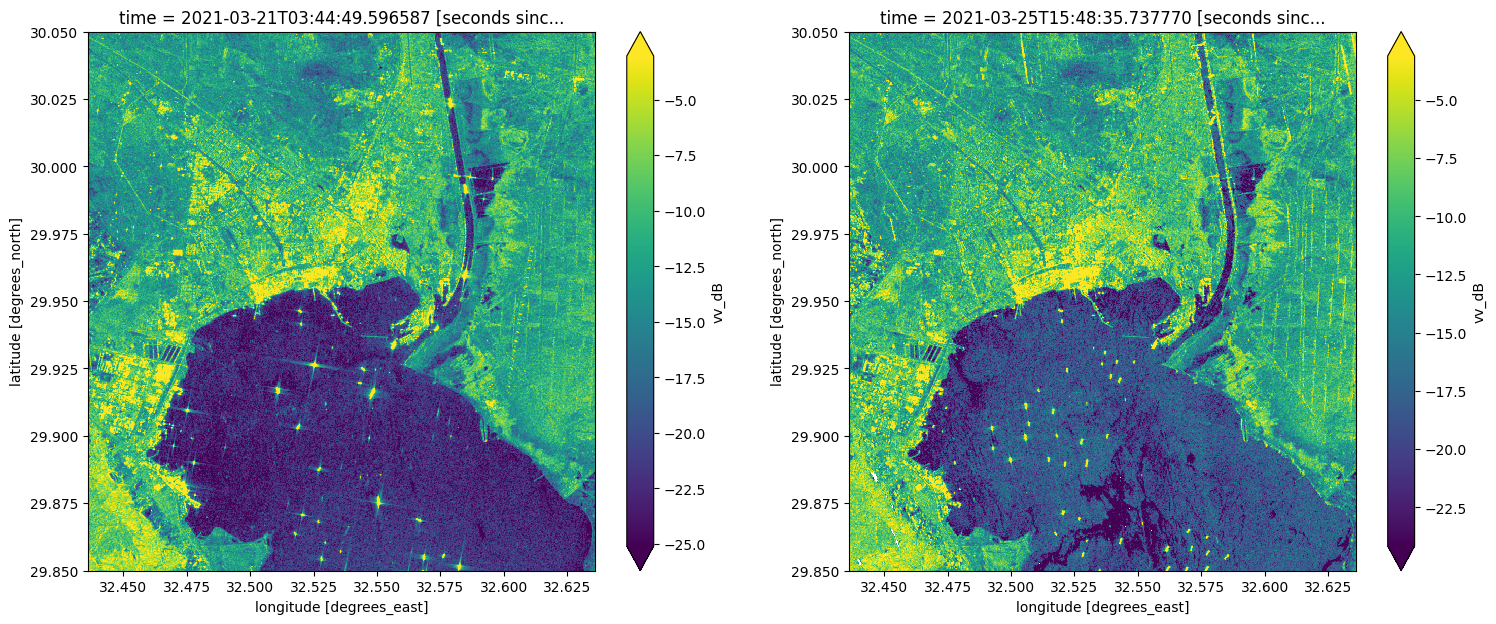

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise baseline image before the event
S1.vv_dB.isel(time=0).plot(robust=True, ax=ax1)

# Visualise the image after the event
S1.vv_dB.isel(time=2).plot(robust=True, ax=ax2);

## Extract open water area

Surface water can be mapped by thresholding radar backscatter.
An detailed example is provided in the [radar water detection notebook](Radar_water_detection.ipynb).
To eliminate the impact of ships and waves, both causing elevated backscatter, minimum backscatter values detected over time for each pixel can be used. e.g.

`water_mask = S1.vv.min(dim="time")<0.015`

For this notebook, however, we use another readily available product in DE Africa, namely the Water Observations from Space (WOfS) annual summary to extract the open water area.

The water detection `frequency` measurement of WOfS annual summary from the latest available year is loaded to match the Sentinel-1 pixel grid using the option `like` in `dc.load()` and `bilinear` resampling.

In [8]:
# Load WOfS summary through the datacube
wofs = dc.load(product='wofs_ls_summary_annual',
               measurements=['frequency'],
               like=S1.geobox,
               resampling='bilinear',
               time='2019',
               )

Open water surface is extracted where water has been detected more than 80% of the year.
For an optimal result, the mask is further adjusted to remove gaps and small water bodies.

In [9]:
# Select pixels that are classified as water > 80 % of the year
water_mask = wofs.frequency > 0.8

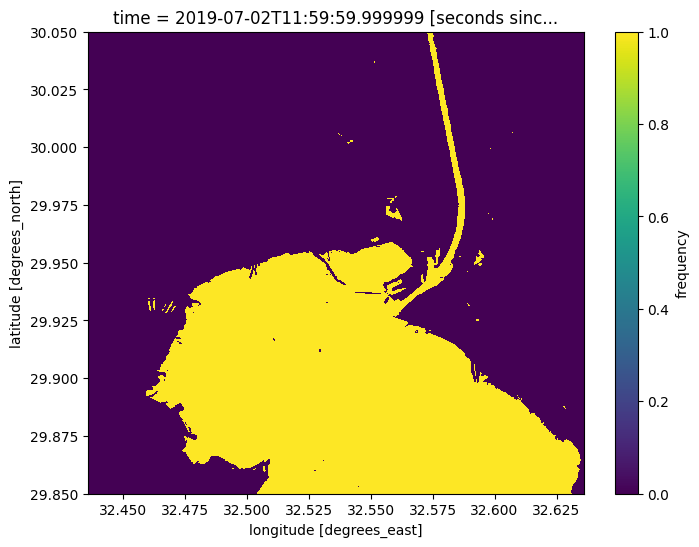

In [10]:
water_mask.plot(size=6);

In [11]:
# close small holes within the water mask and remove a few pixels on the edge for cleaner result
water_mask = xr.DataArray(dilate(~dilate(water_mask, 3, invert=False), 5, invert=True),
                          dims=water_mask.dims).assign_coords(water_mask.coords)

In [12]:
# optional step to select only the largest water body

water_bodies = xr_vectorize(water_mask,
                            crs=S1.crs,  # wofs crs is not recoganized, so using S1 instead as they are the same
                            mask=water_mask.values == 1)

largest = water_bodies[water_bodies.area == water_bodies.area.max()]

# create mask
water_mask = xr_rasterize(largest, S1, crs = S1.crs)

/tmp/ipykernel_8214/1524444574.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  largest = water_bodies[water_bodies.area == water_bodies.area.max()]


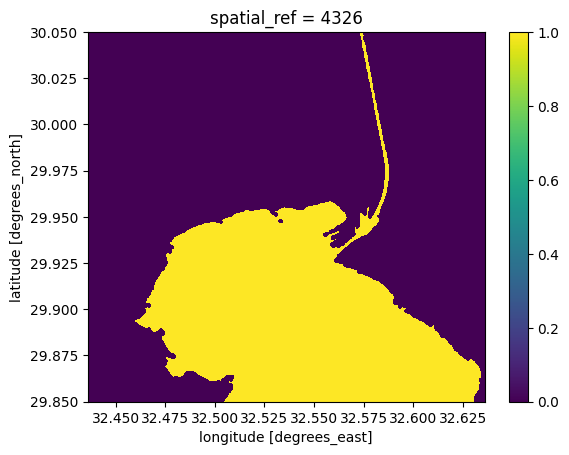

In [13]:
# final water mask
water_mask.plot();

### Apply water mask and threshold for ship detection

In this example, a threshold of 0 dB is chosen. 
Ships are detected where backscatter values are higher than this threshold.
The binary image is vectorised so pixels from the same ship are grouped as one object.  

Visual inspection confirms reasonable detection of large cargo ships.
The threshold can be adjusted for different area and vessel types. 
With known ship locations, the threshold can be optimised using training data.

In [14]:
# set ship detection threshold in vv to 0 dB
ship_vv_db = 0

In [15]:
def detect_ships(da, time_idx, thresh, crs=S1.crs):
    # Thresholding to detect ships
    S1_ships = da.isel(time=time_idx) > thresh
    
    # Check if S1_ships coordinates match water_mask coordinates
    if not (S1_ships.latitude.equals(water_mask.latitude) and S1_ships.longitude.equals(water_mask.longitude)):
        # Convert boolean array to numeric (0 or 1)
        S1_ships_numeric = S1_ships.astype(int)
        
        # Align S1_ships with water_mask's longitude and latitude coordinates
        S1_ships = S1_ships_numeric.interp(latitude=water_mask.latitude, 
                                           longitude=water_mask.longitude,
                                           method='nearest')
    
    S1_ships = S1_ships.where(water_mask.values == 1)
    
    # Vectorize ships
    ships_vector = xr_vectorize(S1_ships,
                                crs=crs,
                                mask=S1_ships.values == 1)
    
    return ships_vector


In [16]:
time_idx = 0
ships_time0 = detect_ships(S1.vv_dB, time_idx, ship_vv_db)
ships_time0.to_file(
    f'ships_{str(S1.time.values[time_idx])[0:10]}.geojson', driver='GeoJSON')
print("Number of ships detected at this time:", len(ships_time0))

Number of ships detected at this time: 51


In [17]:
time_idx = 2
ships_time2 = detect_ships(S1.vv_dB, time_idx, ship_vv_db)
ships_time2.to_file(
    f'ships_{str(S1.time.values[time_idx])[0:10]}.geojson', driver='GeoJSON')
print("Number of ships detected at this time:", len(ships_time2))

Number of ships detected at this time: 69


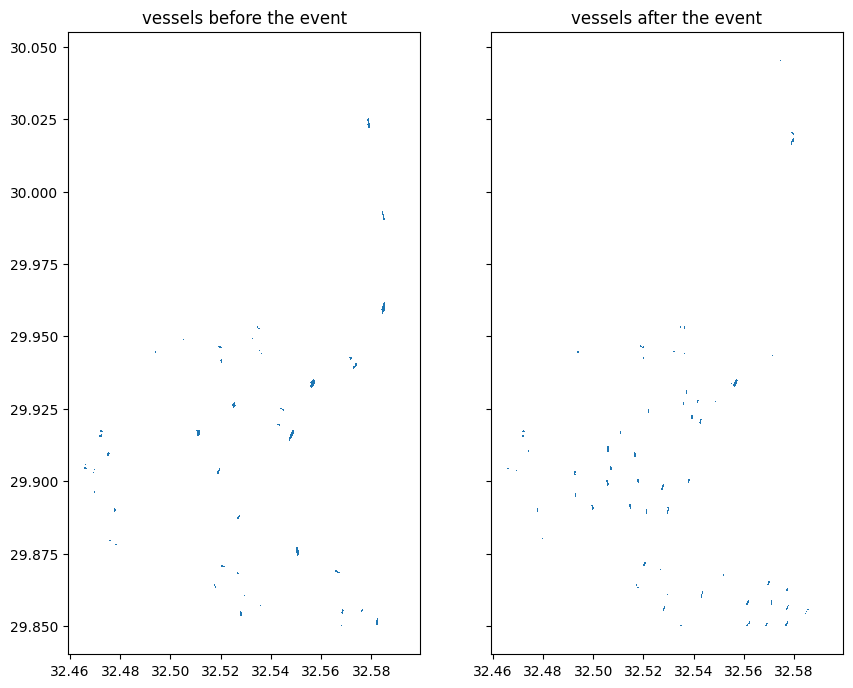

In [18]:
# visualize the ship locations

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
ships_time0.plot(ax=ax[0])
ships_time2.plot(ax=ax[1])
ax[0].set_title('vessels before the event')
ax[1].set_title('vessels after the event');

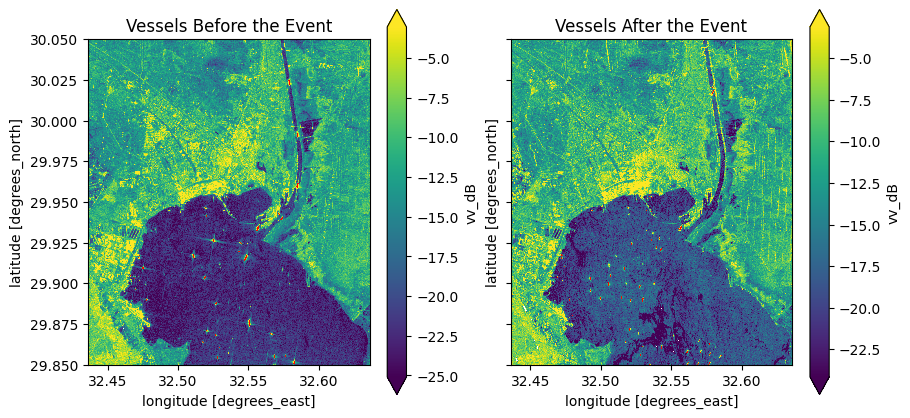

In [19]:
# visualize the ship locations over image

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# Visualize vv_dB underneath ships for the first time index
S1.vv_dB.isel(time=0).plot(robust=True, ax=ax[0])
ships_time0.plot(ax=ax[0], color='red', markersize=50)
ax[0].set_title('Vessels Before the Event')

# Visualize vv_dB underneath ships for the third time index
S1.vv_dB.isel(time=2).plot(robust=True, ax=ax[1])
ships_time2.plot(ax=ax[1], color='red', markersize=50)
ax[1].set_title('Vessels After the Event')

plt.show()

### Caveats and possible improvements

We have applied a simple thresholding method to idenfity ships in the above sections.
Only VV backscatter has been used and no speckle filtering has been done.
This method is based on the assumption that ships produce very high backscatter signals and all bright objects within the water area are ships.

Additional analysis may be help improve the method:
* Threshold for ship pixels are chosen based on visual assessment. The threshold is relatively high so smaller ships may be missed. This threshold may be optimzed with labeled training data for specific use cases.
* It is not clear if all the bright objects near the piers are ships. The location and shape of the objects may be used to remove false positives.
* Rigid structures onboard the ships may result in multiple disconnected bright spots over one ship. These smaller objects may be grouped to give more reliable ship count.

Despite the above limitations, we demonstrate that with a few analysis steps, DE Africa's Sentinel-1 backscatter can be used to detect and count large ships.

## Identify shipping lanes

Ship locations detected across time can be used to map out popular routes.

In the cells below, we load all Sentinel-1 observations from 2020.
Plotting maximum backscatter values over time allows clear identification of the shipping lanes.

Data is lazy-loaded using the `dask_chunks` options to reduce memory requirement.

In [20]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time='2020',
              group_by="solar_day",
              dask_chunks={},
              )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 227 time steps as a dask array


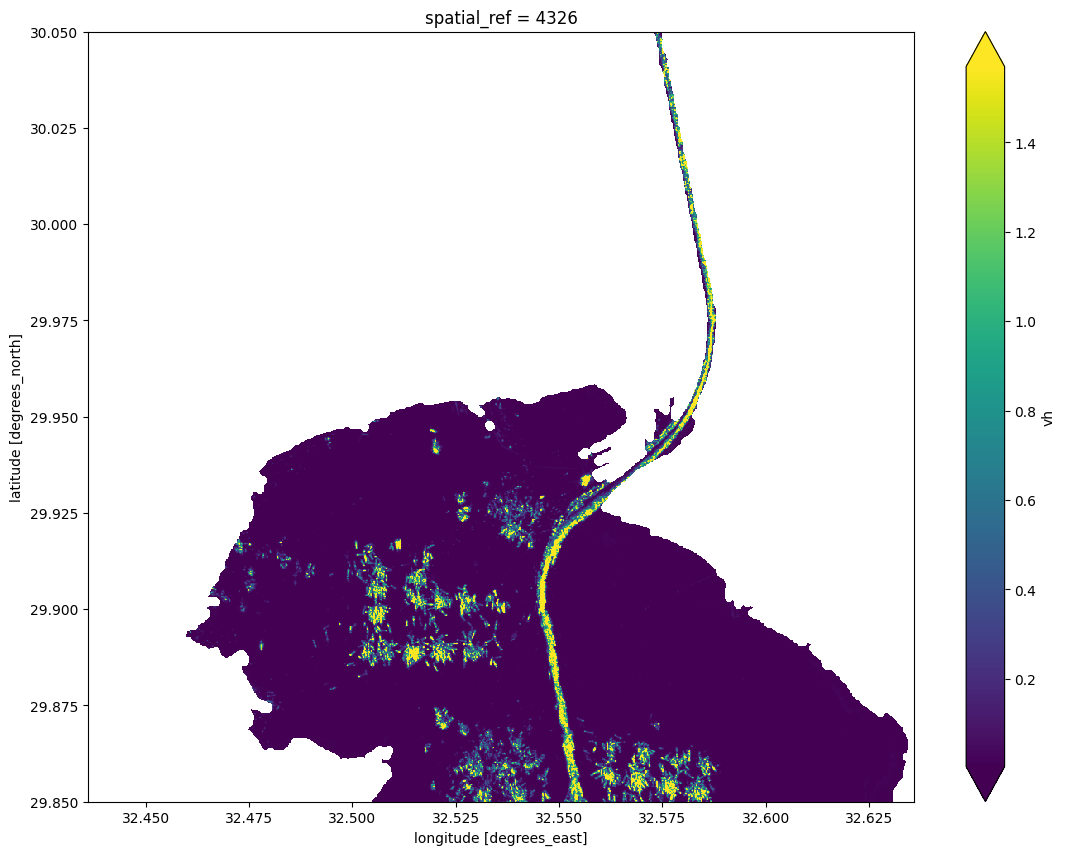

In [21]:
# rereate the water mask using the newly loaded S1 to rasterise the largest water body
water_mask = xr_rasterize(largest, S1)

S1.vh.where(water_mask.values == 1).max(dim='time').plot.imshow(robust=True, size=10);

## Next steps

When you are done, return to the "Set up analysis" cell, modify some values (e.g. `latitude` and `longitude`) and rerun the analysis.

There are a number of key ports covered by Sentinel-1 data in Africa. 
The available data can be viewed on the [DEAfrica Explorer](https://explorer.digitalearth.africa/products/s1_rtc), but we also list the latitude and longitude coordinates for a few key ports below.

**Port of Durban in South Africa**

```
latitude = -29.87
longitude = 31.03
```
 
**Port of Dar Es Salaam in Tanzania** 

```
latitude = -6.83
longitude = 39.29
```

**Port de Tanger Med in Morocco**

```
latitude = 35.86
longitude = -5.53
```

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [22]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [23]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-16'